# Tensorflow predict

## Required Version
OS = ubuntu 16.04
python = 3.7.9
tensorflow-gpu = 2.3.1

## Import Lib

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [33]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumGothicCoding-Bold'

예측 항목 정의

In [3]:
target_col = '수온'

## Load File
엑셀 파일을 로드하고 첫번째 행의 날짜 데이터를 추출

.to_datetime(utc=True) => False인경우 sin, cos 시작점이 달라짐

In [4]:
df = pd.read_excel("./data/8/1.xlsx")
# slice [start:stop:step], starting from index 5 take every 6th record.
# df = df[0::1]
#df1['측정날짜']
date_time = pd.to_datetime(df.pop('측정날짜'), format='%Y.%m.%d %H:%M', utc=True)
# date_time = pd.to_datetime(df['측정날짜'], format='%Y.%m.%d %H:%M:%S')
date_time
#date_time1 = pd.to_datetime(df1['date'])

0      2019-01-01 00:00:00+00:00
1      2019-01-01 01:00:00+00:00
2      2019-01-01 02:00:00+00:00
3      2019-01-01 03:00:00+00:00
4      2019-01-01 04:00:00+00:00
                  ...           
8755   2019-12-31 19:00:00+00:00
8756   2019-12-31 20:00:00+00:00
8757   2019-12-31 21:00:00+00:00
8758   2019-12-31 22:00:00+00:00
8759   2019-12-31 23:00:00+00:00
Name: 측정날짜, Length: 8760, dtype: datetime64[ns, UTC]

In [5]:
df.head()

,수온,수소이온농도,전기전도도,용존산소,탁도,총유기탄소,총질소,총인,클로로필-a,미생물_독성지수
0,2.8,6.8,97.0,12.6,0.5,1.4,1.771,0.004,3.8,4.5
1,2.8,6.8,97.0,12.6,0.6,1.4,1.812,0.005,4.1,2.5
2,2.8,6.8,97.0,12.6,0.4,1.4,1.765,0.003,3.8,1.0
3,2.7,6.8,97.0,12.6,0.5,1.4,1.775,0.005,3.9,1.0
4,2.8,6.8,97.0,12.5,0.5,1.4,1.774,0.004,3.9,-0.4


각 colum의 값에 대한 그래프화...

/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 52509 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/pyth

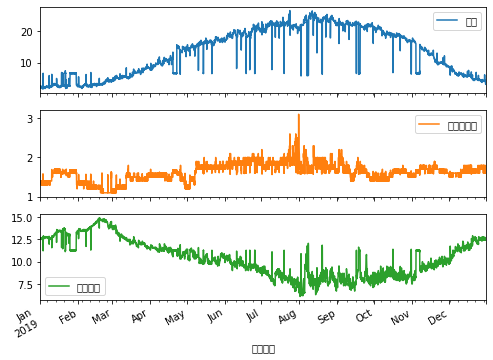

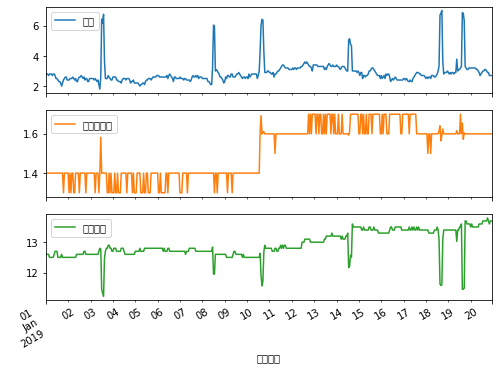

In [34]:
plot_cols = ['수온', '총유기탄소', '용존산소']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)
    
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

data set에 대한 통계

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
수온,8760.0,13.490106,7.345958,1.800,6.300,14.800000,20.600,26.400
수소이온농도,8760.0,6.913934,0.235367,6.200,6.700,6.900000,7.100,7.700
전기전도도,8760.0,111.711030,10.564421,73.000,103.000,111.000000,119.000,168.000
용존산소,8760.0,10.350892,2.069806,6.100,8.500,10.200000,11.900,14.900
탁도,8760.0,1.285492,1.550086,0.300,0.800,1.100000,1.400,83.600
총유기탄소,8760.0,1.619374,0.225519,1.100,1.500,1.600000,1.800,3.100
총질소,8760.0,1.692286,0.230971,0.883,1.575,1.763000,1.852,2.657
총인,8760.0,0.005450,0.003924,0.000,0.003,0.004958,0.007,0.027
클로로필-a,8760.0,8.897064,5.853796,0.500,4.200,7.200000,11.900,28.900
미생물_독성지수,8760.0,-0.037655,1.548039,-16.500,-0.600,-0.006588,0.500,15.700


## Add sin, cos column
시계열의 주기를 알려주기 위한 sin, cos 항목 추가

In [8]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [9]:
day = 24*60*60
week = day * 7
year = (365.2425)*day
    
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
#df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
#df['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [10]:
df.head()

,수온,수소이온농도,전기전도도,용존산소,탁도,총유기탄소,총질소,총인,클로로필-a,미생물_독성지수,Day sin,Day cos,Year sin,Year cos
0,2.8,6.8,97.0,12.6,0.5,1.4,1.771,0.004,3.8,4.5,-5.030095e-12,1.000000,0.002021,0.999998
1,2.8,6.8,97.0,12.6,0.6,1.4,1.812,0.005,4.1,2.5,2.588190e-01,0.965926,0.002738,0.999996
2,2.8,6.8,97.0,12.6,0.4,1.4,1.765,0.003,3.8,1.0,5.000000e-01,0.866025,0.003455,0.999994
3,2.7,6.8,97.0,12.6,0.5,1.4,1.775,0.005,3.9,1.0,7.071068e-01,0.707107,0.004172,0.999991
4,2.8,6.8,97.0,12.5,0.5,1.4,1.774,0.004,3.9,-0.4,8.660254e-01,0.500000,0.004888,0.999988


Text(0.5, 1.0, 'Time of day signal')

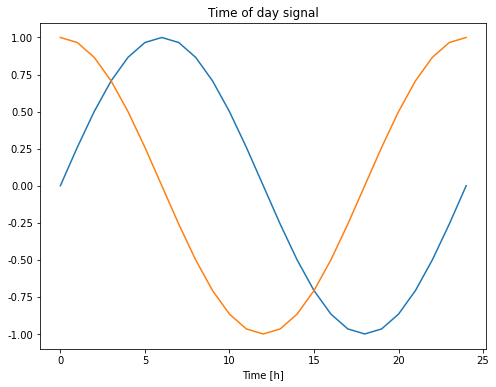

In [12]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of day signal')

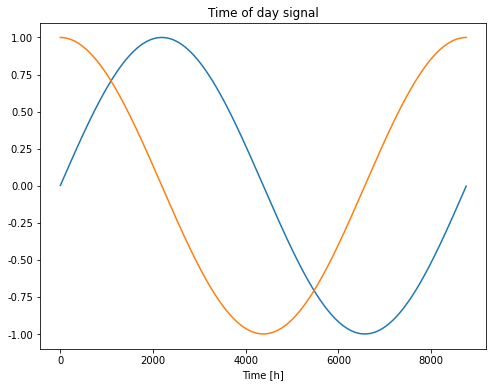

In [13]:
plt.plot(np.array(df['Year sin'])[:25*365])
plt.plot(np.array(df['Year cos'])[:25*365])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

### Split the data

training : validation : test = 7:2:1

In [14]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### 데이터 정규화 

평균, 표준편차 이용

In [15]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

각 항목 분포 시각화 

/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45453 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/pyth

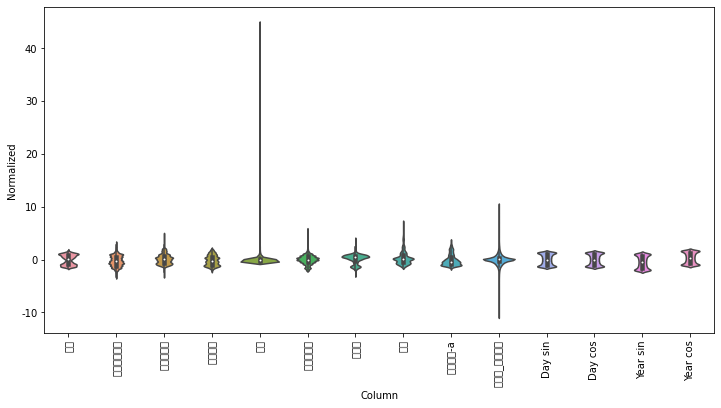

In [35]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

### window 생성 함수 

In [36]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

예)6시간 데이터로 1시간 예측 예시 

In [37]:
w1 = WindowGenerator(input_width=7, label_width=1, shift=1,
                     label_columns=[target_col])
w1

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['수온']

### 2. Split
주어진 window를 input과 label 로 분할하는 함수 
WindowGenerator에 split_window기능 추가 

In [38]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

TEST

In [39]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 8, 14)
Inputs shape: (3, 7, 14)
labels shape: (3, 1, 1)


In [40]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 8, 14)
Inputs shape: (3, 7, 14)
labels shape: (3, 1, 1)


### 3. Plot

시각화 하기 위한 plot 정의 
- 실제 모델 학습 후에 예측 실행되는 부분도 plot에 있다.
WindowGenerator에 plot기능 추가 

split_window 의 결과값 example_inputs, example_labels

In [41]:
w1.example = example_inputs, example_labels
#w1.example

In [42]:
def plot(self, model=None, plot_col=target_col, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


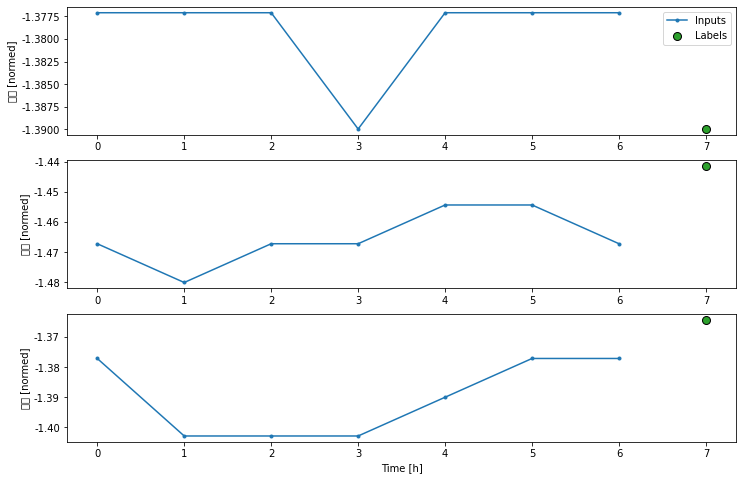

In [43]:
w1.plot()

### 4. Create tf.data.Dataset

input_window, label_window를 tf.data.Dataset으로 변환
WindowGenerator에 make_dataset기능 추가 

In [44]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

tf.data.Datasets 로 액세스하기위한 속성을 추가(train, val, test)
WindowGenerator에 추가

In [45]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Test

In [46]:
# Each element is an (inputs, label) pair
w1.train.element_spec

(TensorSpec(shape=(None, 7, 14), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [47]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 7, 14)
Labels shape (batch, time, features): (32, 1, 1)


## 단일 step model 

1시간 사용 1시간 예측 모델 T0 -> T1 

In [48]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[target_col])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['수온']

The `window` object creates `tf.data.Datasets` from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [49]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 14)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

성능 기준선

In [50]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [51]:
baseline = Baseline(label_index=column_indices[target_col])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

55/55 [==============================] - 0s 955us/step - loss: 0.0141 - mean_absolute_error: 0.0215


24시간 데이터 1시간 예측 (단순 1시간 쉬프트된 그림...)

In [52]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[target_col])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['수온']

In [53]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 14)
Output shape: (32, 24, 1)


/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


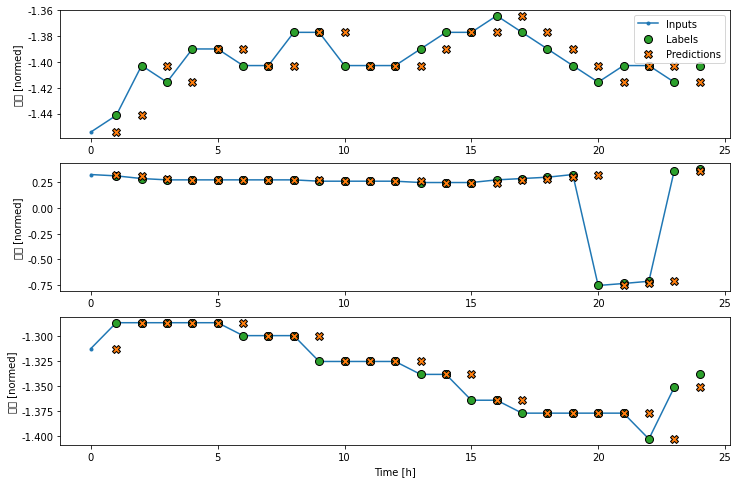

In [54]:
wide_window.plot(baseline)

### 선형 model
단순 layers.Dense 사용

In [55]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [56]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 14)
Output shape: (32, 1, 1)


모델 학습

In [57]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [58]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
192/192 [==============================] - 0s 2ms/step - loss: 2.0159 - mean_absolute_error: 1.1846 - val_loss: 1.3469 - val_mean_absolute_error: 0.9321
Epoch 2/50
192/192 [==============================] - 0s 2ms/step - loss: 0.8316 - mean_absolute_error: 0.7385 - val_loss: 0.6280 - val_mean_absolute_error: 0.6420
Epoch 3/50
192/192 [==============================] - 0s 2ms/step - loss: 0.3838 - mean_absolute_error: 0.4903 - val_loss: 0.3201 - val_mean_absolute_error: 0.4662
Epoch 4/50
192/192 [==============================] - 0s 2ms/step - loss: 0.1937 - mean_absolute_error: 0.3410 - val_loss: 0.2142 - val_mean_absolute_error: 0.3846
Epoch 5/50
192/192 [==============================] - 0s 2ms/step - loss: 0.1119 - mean_absolute_error: 0.2521 - val_loss: 0.1612 - val_mean_absolute_error: 0.3334
Epoch 6/50
192/192 [==============================] - 0s 2ms/step - loss: 0.0733 - mean_absolute_error: 0.1977 - val_loss: 0.1213 - val_mean_absolute_error: 0.2877
Epoch 7/50
192/1

In [59]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 14)
Output shape: (32, 24, 1)


모델 학습 후 wide_window를 입력하여 예측한 결과 시각화 

/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


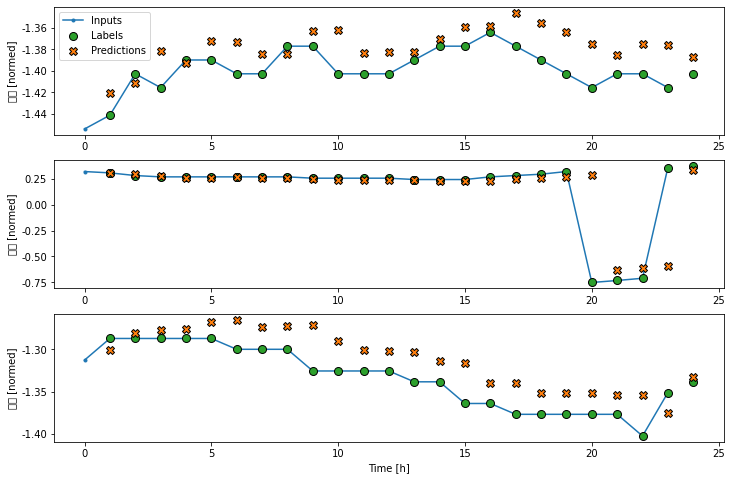

In [60]:
wide_window.plot(linear)

레이어의 가중치 시각화

/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45453 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/pyth

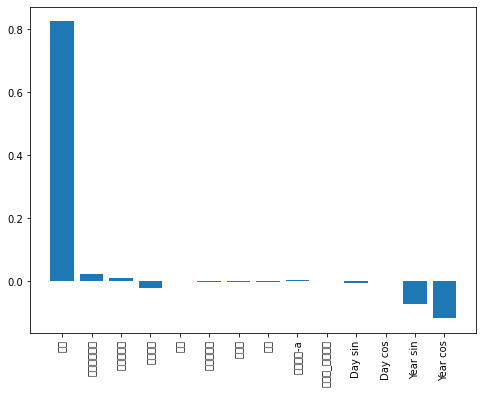

In [61]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### Multi dense
24시간 입력 1시간 예측

In [75]:
CONV_WIDTH = 24
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[target_col])

conv_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['수온']

/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


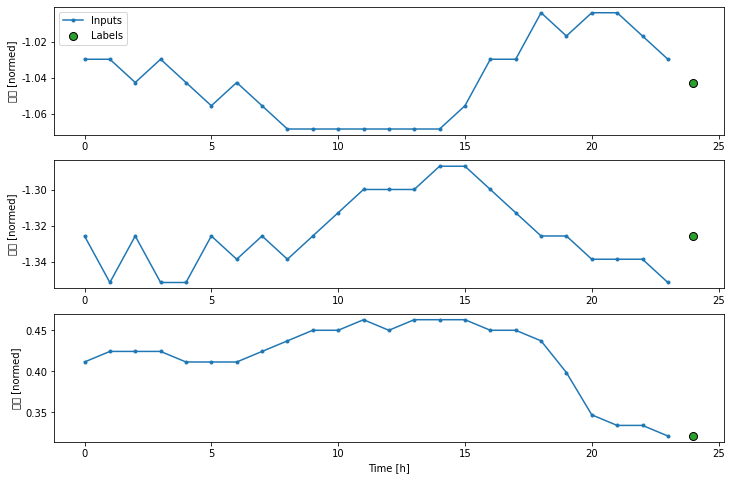

In [76]:
conv_window.plot()

모델 정의

In [64]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [65]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 24, 14)
Output shape: (32, 1, 1)


학습

In [66]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

54/54 [==============================] - 0s 1ms/step - loss: 0.0612 - mean_absolute_error: 0.1586


/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


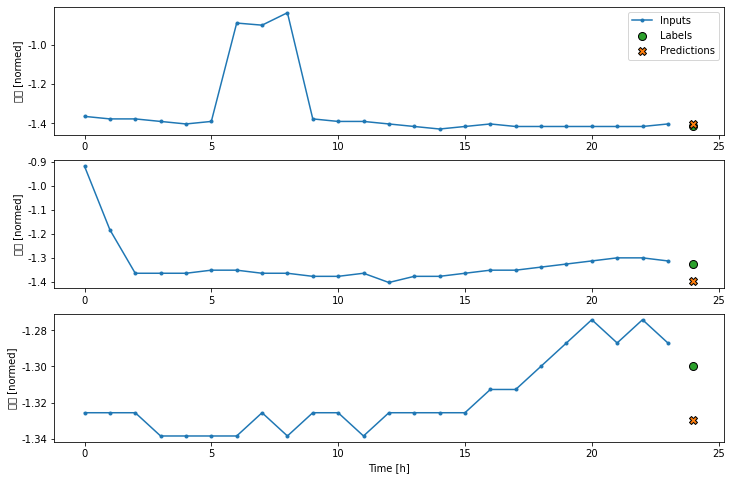

In [67]:
conv_window.plot(multi_step_dense)

### Convolution neural network
 
multi_step_dense 의 첫 Flatten 과 Dense 대신 Conv1D사용

In [68]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [69]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 24, 14)
Output shape: (32, 1, 1)


In [70]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

54/54 [==============================] - 0s 1ms/step - loss: 0.0612 - mean_absolute_error: 0.1557


/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


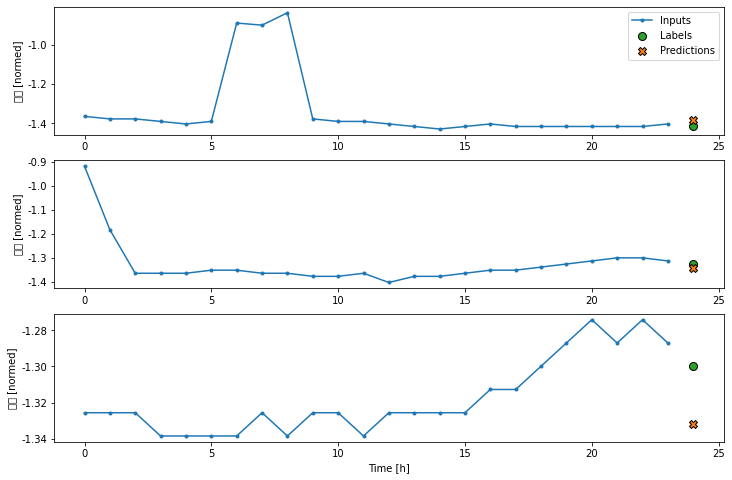

In [71]:
conv_window.plot(conv_model)

입력과 출력의 길이가 일치하도록 새로 widowgenerator빌드

In [72]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=[target_col])

wide_conv_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['수온']

In [73]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 47, 14)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


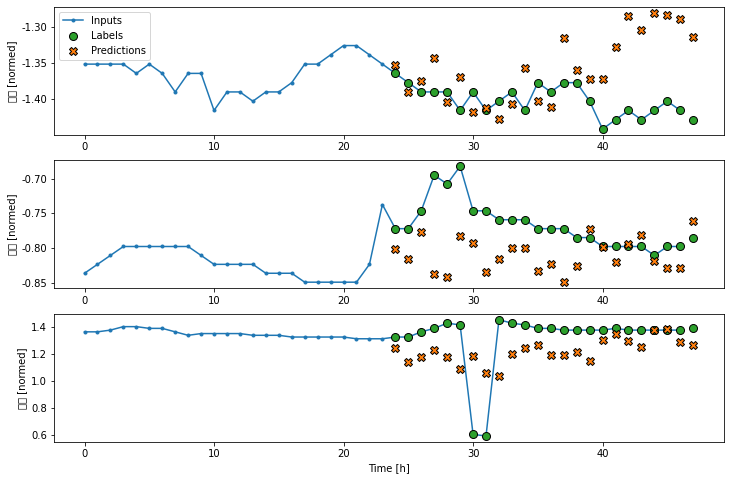

In [74]:
wide_conv_window.plot(conv_model)

### RNN

return_sequences
    False : 모델의 마지막 시간 단계 출력만 반환 (주로 1시간 예측시 사용)
    True : 모든 시간 단계 출력을 반환 (여러시간 예측시 사용)

In [77]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [78]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape(lstm1):', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 14)
Output shape(lstm1): (32, 24, 1)


LSTM 학습

In [79]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

54/54 [==============================] - 0s 2ms/step - loss: 0.0477 - mean_absolute_error: 0.1534


/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


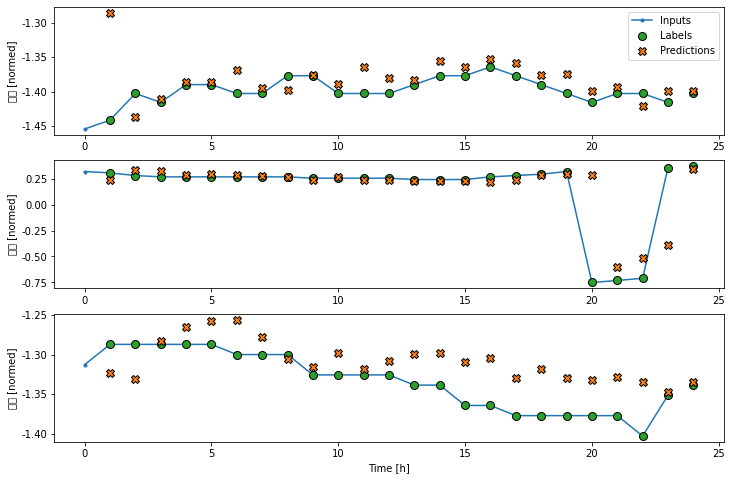

In [80]:
wide_window.plot(lstm_model)

### 성능 평가

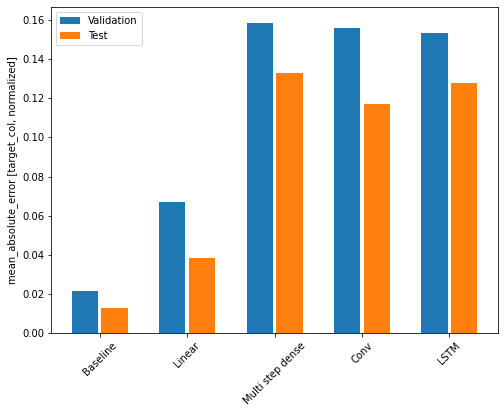

In [81]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [target_col, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [82]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0130
Linear      : 0.0382
Multi step dense: 0.1328
Conv        : 0.1169
LSTM        : 0.1278


### 다중 출력 models

In [83]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 14)
Labels shape (batch, time, features): (32, 24, 14)


#### Baseline

In [84]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [85]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

54/54 [==============================] - 0s 982us/step - loss: 0.1154 - mean_absolute_error: 0.1371


/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


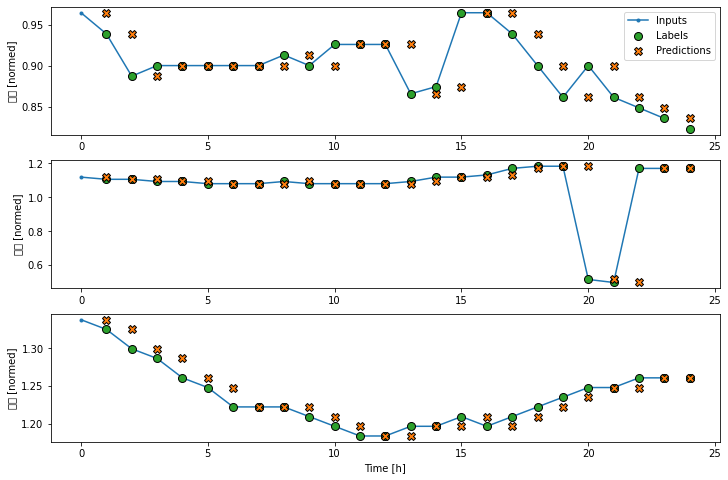

In [86]:
wide_window.plot(baseline)

#### Dense

In [87]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [88]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

55/55 [==============================] - 0s 1ms/step - loss: 0.1656 - mean_absolute_error: 0.2763


/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


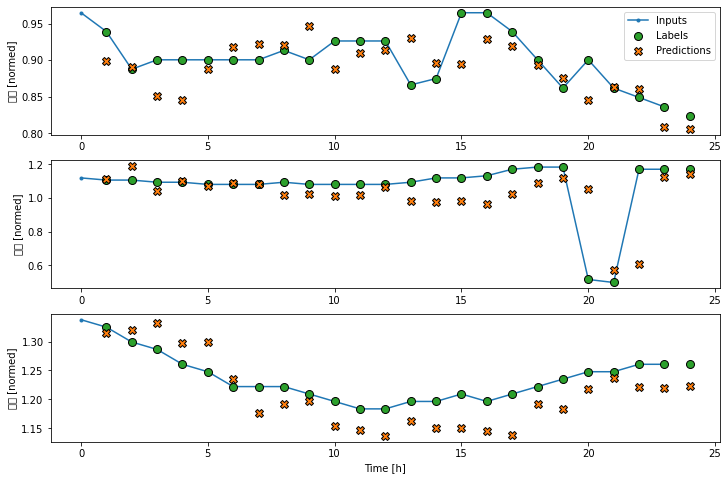

In [89]:
wide_window.plot(dense)

#### RNN


In [90]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

54/54 [==============================] - 0s 2ms/step - loss: 0.1266 - mean_absolute_error: 0.2118

CPU times: user 16.4 s, sys: 2.44 s, total: 18.8 s
Wall time: 8.09 s


/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


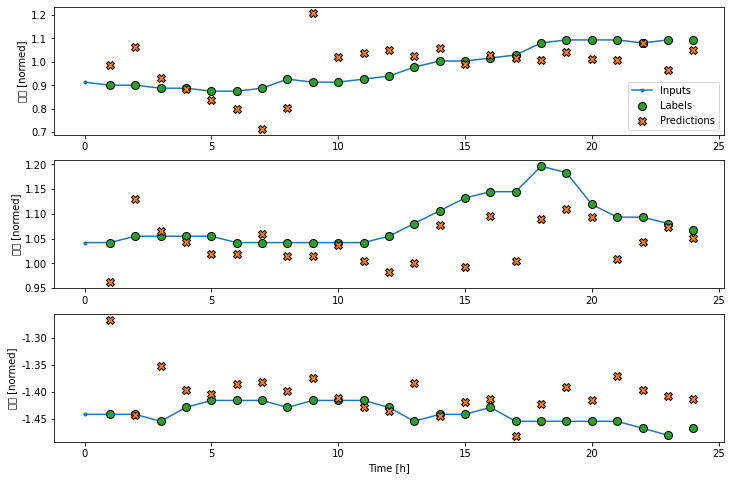

In [91]:
wide_window.plot(lstm_model)

### ResidualWrapper

This approach can be used in conjunction with any model discussed in this tutorial. 

Here it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [92]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [93]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

54/54 [==============================] - 0s 2ms/step - loss: 0.0869 - mean_absolute_error: 0.1236

CPU times: user 5.58 s, sys: 658 ms, total: 6.24 s
Wall time: 3.31 s


/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


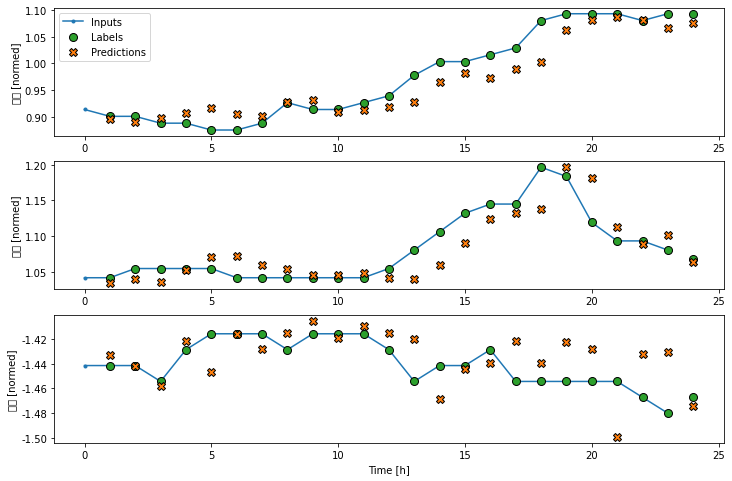

In [94]:
wide_window.plot(residual_lstm)

#### 성능평가

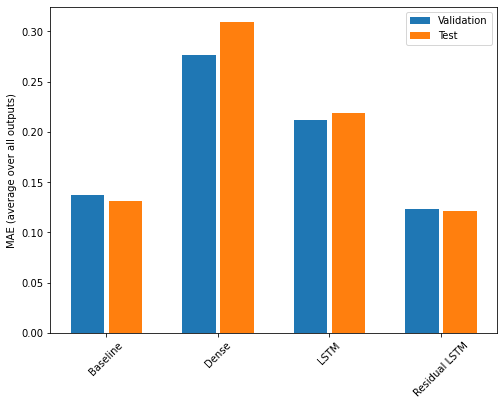

In [95]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [96]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1308
Dense          : 0.3089
LSTM           : 0.2188
Residual LSTM  : 0.1210


## 멀티 step models (many to many)


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


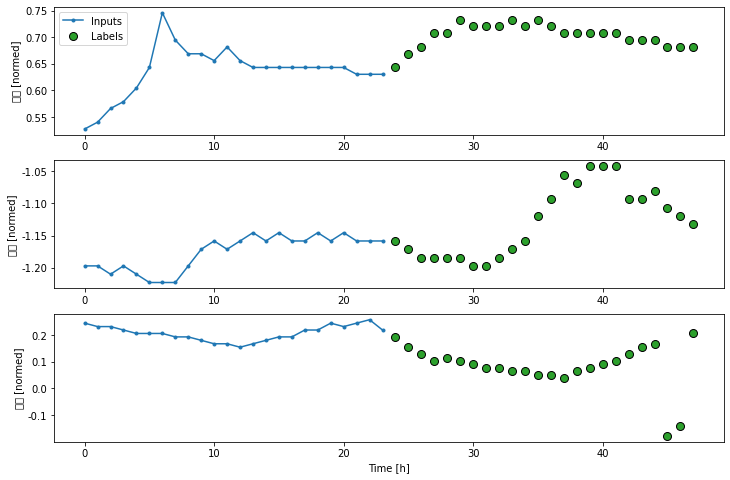

In [97]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

단순히 마지막 시간의 값을 예측 시간만큼 반복

54/54 [==============================] - 0s 1ms/step - loss: 0.5121 - mean_absolute_error: 0.3576


/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


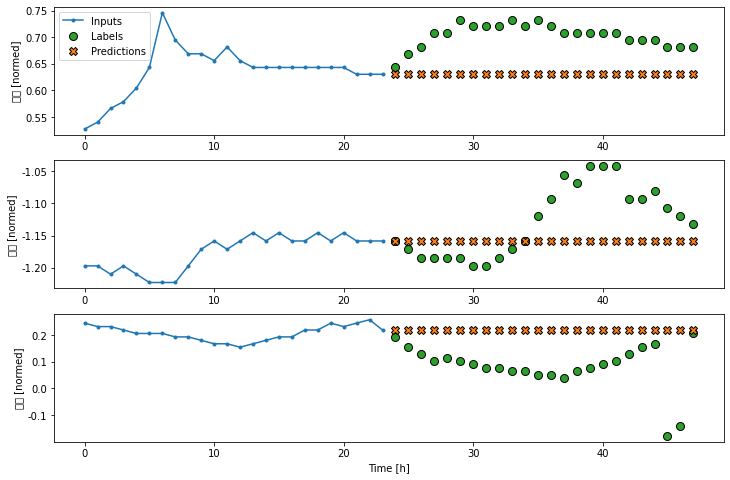

In [98]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Repaet 는 과거 24시간의 데이터를 미래의 24시간 데이터로 복사 (어제와 오늘이 비슷할것이다라는 가정에서 반복)

54/54 [==============================] - 0s 1ms/step - loss: 0.2674 - mean_absolute_error: 0.2173


/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


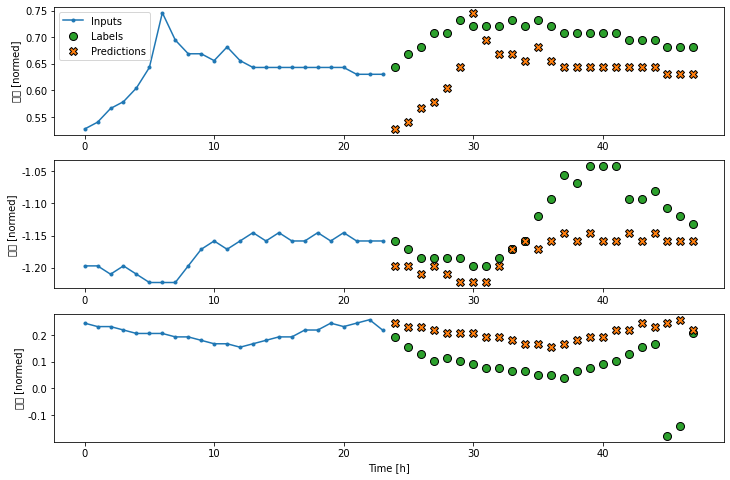

In [99]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs
    
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

#### Linear

54/54 [==============================] - 0s 1ms/step - loss: 0.1791 - mean_absolute_error: 0.2317


/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


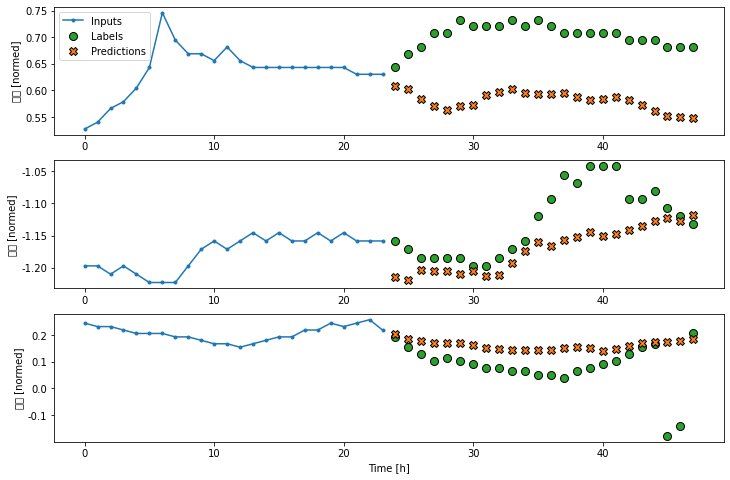

In [100]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

54/54 [==============================] - 0s 1ms/step - loss: 0.2039 - mean_absolute_error: 0.2699


/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


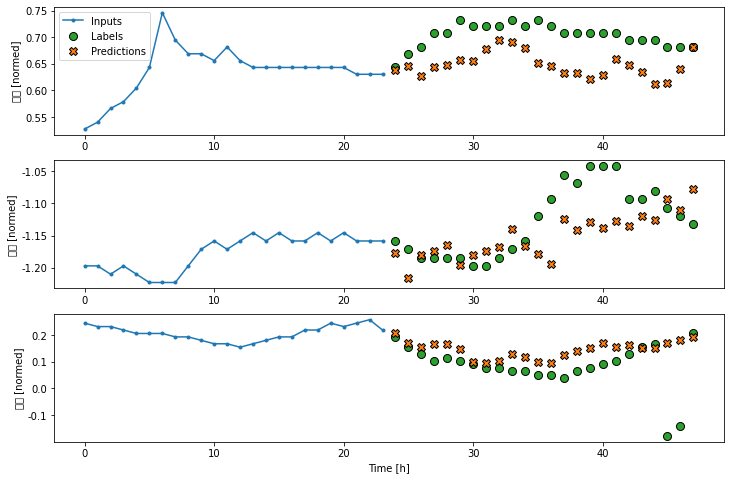

In [101]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

54/54 [==============================] - 0s 1ms/step - loss: 0.2155 - mean_absolute_error: 0.2767


/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


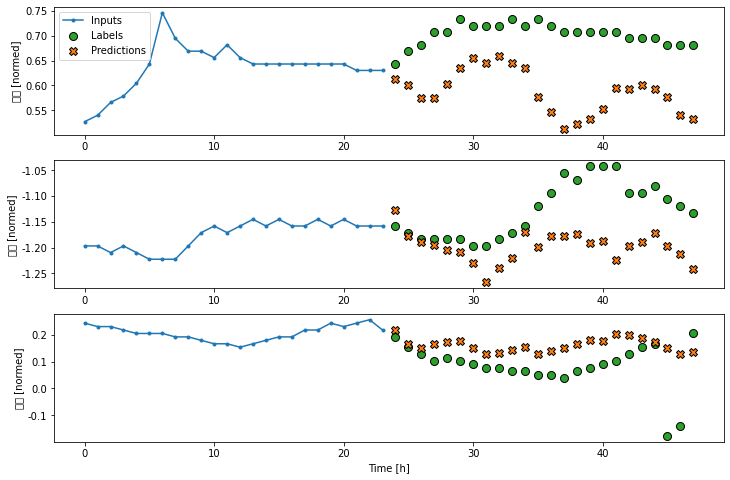

In [102]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

54/54 [==============================] - 0s 1ms/step - loss: 0.3414 - mean_absolute_error: 0.4066


/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


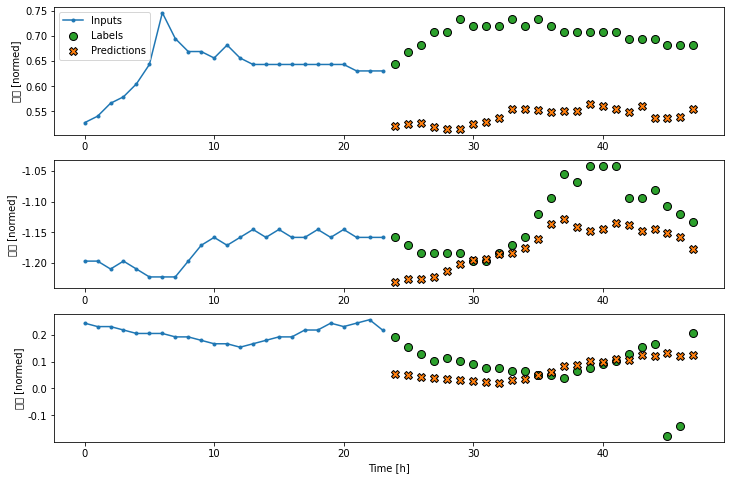

In [103]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Autoregressive model

반복 신경망을 사용

#### RNN


In [104]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [105]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [106]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction, and the internal state of the LSTM:

In [107]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 14])

In [109]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [110]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 14)


학습

54/54 [==============================] - 0s 4ms/step - loss: 0.6076 - mean_absolute_error: 0.5716


/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


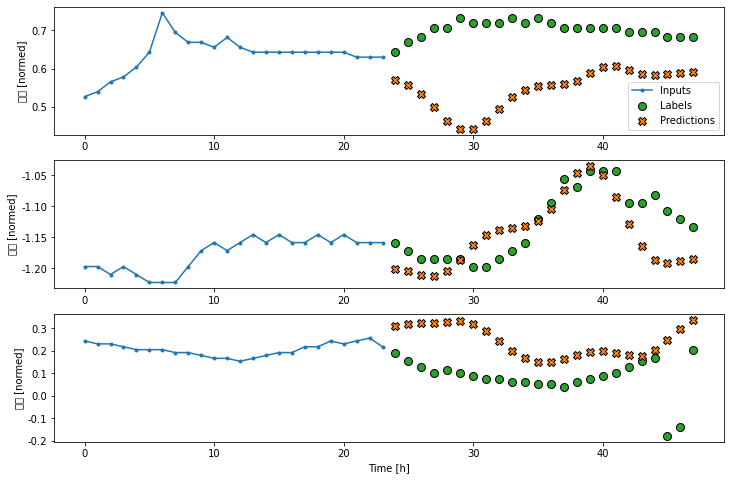

In [111]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### 성능평가

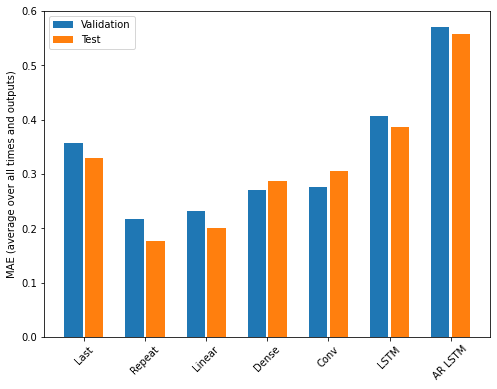

In [112]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [171]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.3671
Repeat  : 0.0445
Linear  : 0.0505
Dense   : 0.0738
Conv    : 0.0824
LSTM    : 0.2332
AR LSTM : 0.1816
